<a href="https://colab.research.google.com/github/22ananya/MUSI6201/blob/main/Final%20Project%20-%20Stereo%20Demixing/Spectrograms_Effects_of_Reweighting_and_HA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import generally required packages - update as needed

In [1]:
# Import dependencies
import numpy as np
import matplotlib.pyplot as plt
import librosa
import scipy.signal as sp
import scipy.io.wavfile as wav

Import/Install the prerequisite code for implementing the Cadenza challenge - includes baselines, other important files

In [2]:
!pip install pyclarity==0.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 62.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 78.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 17.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 54.1 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filena

Import the dataset for the Cadenza challenge directly through the Google Drive link - Only needs to be done once! So now commented out


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Check current path

In [4]:
import os
print(os.getcwd())

/content


Change current path to Cadenza folder

In [5]:
os.chdir('/content/drive/MyDrive/Cadenza_Challenge/cad_icassp_2024/Validation')
print(os.getcwd())

/content/drive/MyDrive/Cadenza_Challenge/cad_icassp_2024/Validation


#Process single audio file through the entire model step by step

Import all dependencies - same as enhance.py file

In [6]:
from __future__ import annotations

import json
import logging
from pathlib import Path

# pylint: disable=import-error
import hydra
import numpy as np
import torch
from numpy import ndarray
from omegaconf import DictConfig
from torchaudio.pipelines import HDEMUCS_HIGH_MUSDB

from clarity.enhancer.compressor import Compressor
from clarity.enhancer.nalr import NALR
from clarity.evaluator.haaqi import compute_haaqi
from clarity.utils.audiogram import Audiogram, Listener
from clarity.utils.file_io import read_signal
from clarity.utils.flac_encoder import FlacEncoder
from clarity.utils.results_support import ResultsFile
from clarity.utils.signal_processing import (
    clip_signal,
    denormalize_signals,
    normalize_signal,
    resample,
    to_16bit,
    compute_rms,
    resample,
)
from clarity.utils.source_separation_support import get_device, separate_sources
from recipes.cad_icassp_2024.baseline.evaluate import (
    apply_gains,
    apply_ha,
    make_scene_listener_list,
    remix_stems,
    load_reference_stems,
)

logger = logging.getLogger(__name__)

/usr/local/lib/python3.10/dist-packages/recipes/cad_icassp_2024/baseline/evaluate.py:190: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="", config_name="config")


Import all the required functions defined in Enhance.py that do not need to be changed

In [7]:
from recipes.cad_icassp_2024.baseline.enhance import (
    save_flac_signal,
    decompose_signal,
    process_remix_for_listener
)

/usr/local/lib/python3.10/dist-packages/recipes/cad_icassp_2024/baseline/enhance.py:182: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="", config_name="config")


Import the correct config file (hardcoded location)

In [8]:
from omegaconf import OmegaConf
config = OmegaConf.load('config.yaml')
print(config.separator.model)

demucs


Set output directory

In [43]:
enhanced_folder = Path("Val_Ref_Tracks")
enhanced_folder.mkdir(parents=True, exist_ok=True)

Load listener data

In [44]:
config.path.root = '/content/drive/MyDrive/Cadenza_Challenge/cad_icassp_2024/Validation'
print(config.path)


{'root': '/content/drive/MyDrive/Cadenza_Challenge/cad_icassp_2024/Validation', 'metadata_dir': '${path.root}/metadata', 'music_dir': '${path.root}/audio/at_mic_music', 'gains_file': '${path.metadata_dir}/gains.json', 'head_positions_file': '${path.metadata_dir}/head_positions.json', 'listeners_file': '${path.metadata_dir}/listeners.valid.json', 'music_file': '${path.metadata_dir}/at_mic_music.valid.json', 'scenes_file': '${path.metadata_dir}/scenes.valid.json', 'scene_listeners_file': '${path.metadata_dir}/scene_listeners.valid.json', 'exp_folder': './exp'}


In [45]:
# Load listener audiograms and songs
listener_dict = Listener.load_listener_dict(config.path.listeners_file)

with Path(config.path.gains_file).open("r", encoding="utf-8") as file:
    gains = json.load(file)

with Path(config.path.scenes_file).open("r", encoding="utf-8") as file:
    scenes = json.load(file)

with Path(config.path.scene_listeners_file).open("r", encoding="utf-8") as file:
    scenes_listeners = json.load(file)

with Path(config.path.music_file).open("r", encoding="utf-8") as file:
    songs = json.load(file)

Load the enhancer (NAL-R) and compression setting (OFF)

In [46]:
enhancer = NALR(**config.nalr)
compressor = Compressor(**config.compressor)

Create a list of songs, listeners (audiogram) and head position (hrtf) to generate, or evaluate the mix - based on provided data

In [47]:
# Select a batch to process
scene_listener_pairs = make_scene_listener_list(
    scenes_listeners, config.evaluate.small_test
)

scene_listener_pairs = scene_listener_pairs[
    config.evaluate.batch :: config.evaluate.batch_size
]

In [48]:
print(scene_listener_pairs[0])

('scene_50001', 'L5020')


# Create a function to plot spectrograms

In [49]:
from scipy.signal import stft, istft
def plot_spectrogram(mix, nfft=4096, n_olap=512, title="Spectrogram", samplerate=44100, plotchannel=0):

    f, t, X = stft(np.swapaxes(mix,0,1),fs = samplerate,nperseg=4096, noverlap=512)
    # convert to log scale
    X = librosa.amplitude_to_db(np.abs(X))#, ref=np.max)
    fig, ax = plt.subplots()
    img = plt.pcolormesh(t, f, X[plotchannel,:,:], cmap = 'plasma', shading='gouraud')
    fig.colorbar(img, ax=ax, format="%+2.0f dB")
    ax.set_title(title)
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    plt.show()

    return

In [50]:
from recipes.cad_icassp_2024.baseline.evaluate import level_normalisation
previous_song = ""
num_scenes = len(scene_listener_pairs)
nrun = [50] # change to num_scenes for full dataset

for idx in nrun:
    scene_id, listener_id = scene_listener_pairs[idx]

    scene = scenes[scene_id]
    song_name = f"{scene['music']}-{scene['head_loudspeaker_positions']}"

    logger.info(
        f"[{idx:03d}/{num_scenes:03d}] "
        f"Processing {scene_id}: {song_name} for listener {listener_id}"
    )
    # Get the listener's audiogram
    listener = listener_dict[listener_id]
    print(listener.audiogram_left)
    print(listener.audiogram_right)
    print(scene_id, listener_id)
    print(gains[scene["gain"]])


    # Load reference stems and mixture, process step by step and make spectrograms!

    unweighted_stems, original_mixture = load_reference_stems(
        Path(config.path.music_dir) / songs[song_name]["Path"]
    )
    weighted_stems = apply_gains(
        unweighted_stems, config.sample_rate, gains[scene["gain"]]
    )
    pre_HA_mixture = remix_stems(
        weighted_stems, original_mixture, config.sample_rate
    )



    # Apply hearing aid to reference signals
    left_reference = apply_ha(
        enhancer=enhancer,
        compressor=None,
        signal=pre_HA_mixture[:, 0],
        audiogram=listener.audiogram_left,
        apply_compressor=False,
    )
    right_reference = apply_ha(
        enhancer=enhancer,
        compressor=None,
        signal=pre_HA_mixture[:, 1],
        audiogram=listener.audiogram_right,
        apply_compressor=False,
    )

    final_mixture = np.stack([left_reference, right_reference], axis=1)
    final_mixture = level_normalisation(final_mixture, original_mixture, config.sample_rate)




Audiogram(levels=array([15, 15, 25, 40, 55, 80, 80, 80]), frequencies=array([ 250,  500, 1000, 2000, 3000, 4000, 6000, 8000]))
Audiogram(levels=array([15, 15, 15, 45, 65, 75, 80, 80]), frequencies=array([ 250,  500, 1000, 2000, 3000, 4000, 6000, 8000]))
scene_50026 L5069
{'vocals': -3, 'drums': 0, 'bass': -10, 'other': -10}


# Plot Audiogram

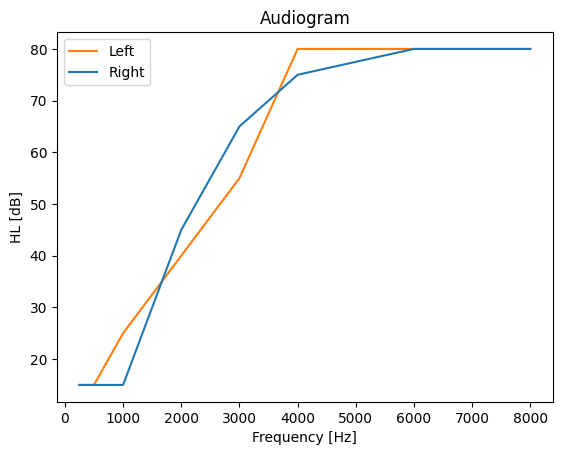

In [51]:
fig, ax = plt.subplots()
ax.plot(listener.audiogram_left.frequencies, listener.audiogram_left.levels, 'tab:orange', label = 'Left')
ax.plot(listener.audiogram_right.frequencies, listener.audiogram_right.levels, 'tab:blue', label = 'Right')
ax.set_ylabel('HL [dB]')
ax.set_xlabel('Frequency [Hz]')
ax.set_title('Audiogram')
ax.legend()
plt.show()

# Plotting!

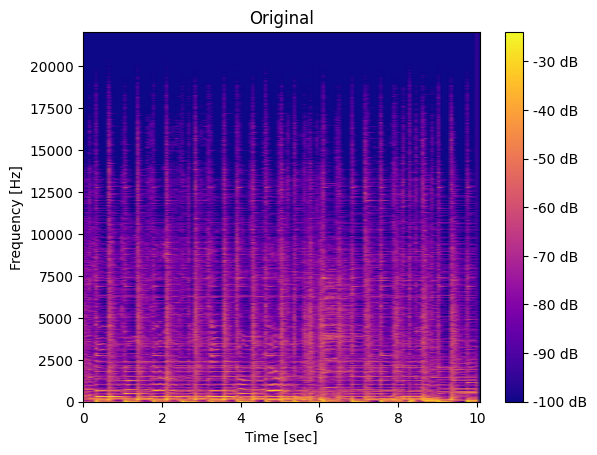

0.446319580078125
0.05989135956710158


In [19]:
from IPython.display import Audio
plot_spectrogram(original_mixture, title="Original")
print(np.max(original_mixture[:,0]))
print(np.mean(np.abs(original_mixture[:,0])))

In [20]:
Audio(original_mixture[:,0], rate=config.sample_rate)

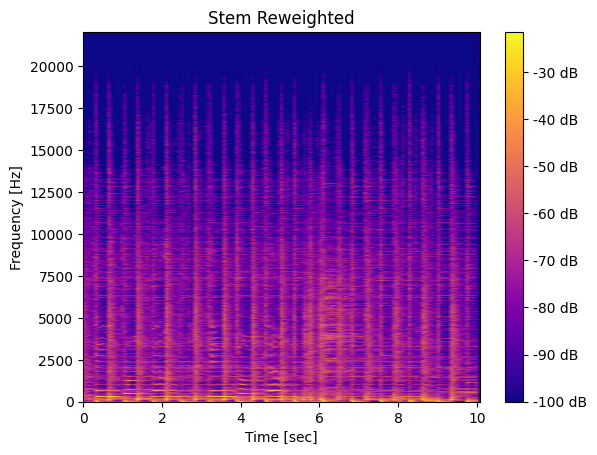

0.5171507919238192
0.05409046636793032


In [21]:
plot_spectrogram(pre_HA_mixture, title="Stem Reweighted")
print(np.max(pre_HA_mixture[:,0]))
print(np.mean(np.abs(pre_HA_mixture[:,0])))

In [22]:
Audio(pre_HA_mixture[:,0], rate=config.sample_rate)

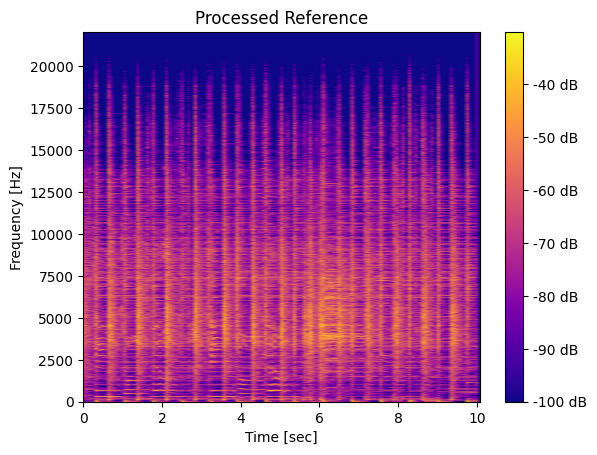

0.6576438082438446
0.030358249663751228


In [42]:
plot_spectrogram(final_mixture, title="Processed Reference")
print(np.max(final_mixture[:,0]))
print(np.mean(np.abs(final_mixture[:,0])))

In [24]:
Audio(final_mixture[:,0], rate=config.sample_rate)

Compare LUFS levels of all 3

In [26]:
import pyloudnorm as pyln
meter = pyln.Meter(int(config.sample_rate))
original_lufs = meter.integrated_loudness(original_mixture)
pre_HA_lufs = meter.integrated_loudness(pre_HA_mixture)
final_lufs = meter.integrated_loudness(final_mixture)

print('Original LUFS: ', original_lufs)
print('Reweighted LUFS: ', pre_HA_lufs)
print('Final LUFS: ', final_lufs)

Original LUFS:  -20.297699493091077
Reweighted LUFS:  -20.297699493091056
Final LUFS:  -20.297699493091077


# Save these wavs!

# Make new directory to save these

In [27]:
example_folder = Path("Example_Signals")
example_folder.mkdir(parents=True, exist_ok=True)

In [28]:
filename = Path(example_folder) / "original_dd.flac"
save_flac_signal(
    signal=original_mixture,
    filename=filename,
    signal_sample_rate=config.sample_rate,
    output_sample_rate=config.remix_sample_rate,
    do_clip_signal=True,
    do_soft_clip=config.soft_clip,
    )

In [29]:
filename = Path(example_folder) / "rebalanced_dd.flac"
save_flac_signal(
    signal=pre_HA_mixture,
    filename=filename,
    signal_sample_rate=config.sample_rate,
    output_sample_rate=config.remix_sample_rate,
    do_clip_signal=True,
    do_soft_clip=config.soft_clip,
    )

In [30]:
filename = Path(example_folder) / "final_dd.flac"
save_flac_signal(
    signal=final_mixture,
    filename=filename,
    signal_sample_rate=config.sample_rate,
    output_sample_rate=config.remix_sample_rate,
    do_clip_signal=True,
    do_soft_clip=config.soft_clip,
    )